# Cognitive complexity and neighborhood structure shape narrative interaction in online social networks

## Hunter Priniski (priniski at u c l a dot e d u)


This data carpentry script turns the dataframes returned by OTree (interaction data) and Qualtrics (pre/post interaction data) into a formats that allows for statitical analysis and visualization. Statistical analyses are performed on a long formatted dataframe in R. 




# Preliminaries

In [24]:
import itertools
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
import json
import networkx as nx
from scipy.spatial import distance
import random
import math
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
from collections import Counter
import seaborn as sns

# Set Seaborn style
sns.set_style("white")
sns.set_palette("hls")


In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

stemmer = PorterStemmer()

ModuleNotFoundError: No module named 'nltk'

# Preliminaries

Run these blocks which provide helper functions for the remainder of code.

In [18]:
def is_int(val):

    try:
        int(val)
        return True

    except ValueError:
        return False

In [19]:
def stem_string(text):

    words = word_tokenize(text)

    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

In [20]:
def process_hashtag_data(data):

  data["id"] = data.index
  data['random ID'] = data['hashtag_experiment.1.player.idx']
  #data['random ID'] = data['random ID'].dropna().astype('int64')

  data_cols = ['.hashtag'] #need leading period becaues network experiment is called hashtag_experiment in OTree
  rejects = ['config', 'network_experiment']
  cols_to_reshape = []
  for col in list(data.columns):
    if any(dc in col for dc in data_cols) and not('current' in col) and not (any(rj in col for rj in rejects)):
        cols_to_reshape.append(col)

  group_cols = ['.id_in_subsession']
  rejects = ['config', 'network_experiment']
  cols_to_reshape2 = []
  for col in list(data.columns):
    if any(dc in col for dc in group_cols) and not('current' in col) and not (any(rj in col for rj in rejects)):
        cols_to_reshape2.append(col)

  data_long = data.melt(id_vars=['id', 'random ID'], value_vars= cols_to_reshape, var_name='VarName', value_name='Response', col_level=None, ignore_index=True)
  data_groups = data.melt(id_vars = ['id', 'random ID'], value_vars = cols_to_reshape2, var_name = 'VarName2', value_name = 'id_in_subsession', col_level = None, ignore_index = True)

  data_long[['ExpName', 'TrialNumber', 'Respondant','ResponseType']] = data_long['VarName'].str.split(".", expand = True)
  data_long['Group'] = data_groups['id_in_subsession']

  data_clean = data_long[['id', 'random ID' ,'ResponseType', 'TrialNumber', 'Response', 'Group']]
  data_clean['TrialNumber'] = data_clean['TrialNumber'].astype('int64')

  data_clean = data_clean[data_clean['ResponseType'] == 'hashtag'].dropna()
  data_clean['Response'] = data_clean['Response'].apply(str.lower)

  return data_clean

In [21]:
def process_facename_data(data, network_experiment2 = False):

  data["id"] = data.index

  if network_experiment2:
    data['random ID'] = data['network_experiment2.1.player.idx']
  else:
    data['random ID'] = data['network_experiment.1.player.idx']

  #list(data.columns)[24:-1]
  data_cols = ['name', 'competence','dominance','maturity','likeability','trustworthiness']
  rejects = ['config']
  cols_to_reshape = []
  for col in list(data.columns):
    if any(dc in col for dc in data_cols) and not('current' in col) and not (any(rj in col for rj in rejects)):
        cols_to_reshape.append(col)

  group_cols = ['id_in_subsession']

  rejects = ['config', 'hashtag_experiment']

  cols_to_reshape2 = []
  for col in list(data.columns):
    if any(dc in col for dc in group_cols) and not('current' in col) and not (any(rj in col for rj in rejects)):
        cols_to_reshape2.append(col)
  #print(data[cols_to_reshape2])

  data_long = data.melt(id_vars=['id', 'random ID'], value_vars= cols_to_reshape, var_name='VarName', value_name='Response', col_level=None, ignore_index=True)
  data_long[['ExpName', 'TrialNumber', 'Respondant','ResponseType']] = data_long['VarName'].str.split(".", expand = True)

  data_groups = data.melt(id_vars = ['id'], value_vars = cols_to_reshape2, var_name = 'VarName2', value_name = 'id_in_subsession', col_level = None, ignore_index = True).dropna()

  if network_experiment2:
    data_groups['TrialNumber'] = data_groups['VarName2'].str.extract(r'2\.(\d+)\.group').astype(int)
  else:
    data_groups['TrialNumber'] = data_groups['VarName2'].str.extract(r'\.(\d+)\.group').astype(int)

  data_clean = data_long[['id', 'random ID', 'ResponseType', 'TrialNumber', 'Response']]
  data_clean['TrialNumber'] = data_clean['TrialNumber'].astype('int64')
  #data_clean['Group'] = data_groups['id_in_subsession']

  data_names = data_clean[data_clean['ResponseType'] == 'name'].dropna()
  data_names['Response'] = data_names['Response'].apply(str.lower)

  #data_names['Group'] = data_groups['id_in_subsession']
  data_names = pd.merge(data_names, data_groups, on=['id', 'TrialNumber']).drop(columns='VarName2')
  data_names.rename(columns={'id_in_subsession': 'Group'}, inplace=True)

  data_impressions = data_clean[data_clean['ResponseType'] != 'name']#.dropna()
  data_impressions['Response'] = data_impressions['Response'].astype('float')
  #data_impressions['Group'] = data_groups['id_in_subsession']

  return data_clean, data_names, data_impressions, data_groups

In [22]:
def to_int64(val):
    try:
        return int(val)
    except (ValueError, TypeError):
        return np.nan

def process_prepost_data(pre_post, ids, underscore = True):

  pre_post['random ID'] = pre_post['random ID'].dropna().astype('int64')

  ids = ids.apply(to_int64).dropna().astype('int64')

  #ids = ids.astype('int64')
  pre_post.fillna('', inplace=True)

  #pre_post['random ID'] = pre_post['random ID'].astype('int64')

  if underscore:
    pre_columns = [f'hashtag1_{i}' for i in range(1, 11)]
    pre_columns.append('tweet1')

    pre_hash = pre_post[pre_columns]

    pre_hash = pre_hash.applymap(str.lower)#.applymap(stem_string)
    pre_hash['random ID'] = pre_post['random ID']

    post_columns = [f'hashtag2_{i}' for i in range(1, 11)]
    post_columns.append('tweet2')

    post_hash = pre_post[post_columns]
    #print(post_hash)
    post_hash = post_hash.applymap(str.lower)#.applymap(stem_string)
    post_hash['random ID'] = pre_post['random ID']

    pre_hash_long = pre_hash.melt(id_vars='random ID', var_name='ResponseItem', value_name='Response')
    pre_hash_long['Response'] = pre_hash_long['Response'].str.replace('#', '', regex=True)
    pre_hash_long = pre_hash_long[pre_hash_long['random ID'].isin(ids)]

    post_hash_long = post_hash.melt(id_vars='random ID', var_name='ResponseItem', value_name='Response')
    post_hash_long['Response'] = post_hash_long['Response'].str.replace('#', '', regex=True)
    post_hash_long = post_hash_long[post_hash_long['random ID'].isin(ids)]

  else:
    pre_hash = pre_post[['hashtag1', 'hashtag2', 'hashtag3', 'hashtag4', 'hashtag5', 'hashtag6', 'hashtag7', 'hashtag8', 'hashtag9', 'hashtag10']]
    #pre_hash = pre_hash.applymap(str.lower).applymap(stem_string)
    pre_hash['random ID'] = pre_post['random ID']

    post_hash = pre_post[['hashtag2.1', 'hashtag2.2', 'hashtag2.3', 'hashtag2.4', 'hashtag2.5', 'hashtag2.6', 'hashtag2.7', 'hashtag2.8', 'hashtag2.9', 'hashtag2.10']]
    #post_hash = post_hash.applymap(str.lower).applymap(stem_string)
    post_hash['random ID'] = pre_post['random ID']

    pre_hash_long = pre_hash.melt(id_vars='random ID', var_name='hashtag_number', value_name='hashtag')
    pre_hash_long['hashtag'] = pre_hash_long['hashtag'].str.replace('#', '', regex=True)
    pre_hash_long = pre_hash_long[pre_hash_long['random ID'].isin(ids)]

    post_hash_long = post_hash.melt(id_vars='random ID', var_name='hashtag_number', value_name='hashtag')
    post_hash_long['hashtag'] = post_hash_long['hashtag'].str.replace('#', '', regex=True)
    post_hash_long = post_hash_long[post_hash_long['random ID'].isin(ids)]

  return pre_hash_long, post_hash_long

In [3]:
#for preparing the long dataframes for a csv to be analyzed in R using BRMS - interaction data only, prepost data is done manually, see below.
def combine_dataframes(dfs):
    combined_df = pd.DataFrame()

    content_mapping = {'h': 'hashtag', 'f': 'facename'}
    structure_mapping = {'h': 'homogeneous', 's': 'spatial'}

    for name, df in dfs.items():
        df_copy = df.copy()
        df_copy['dfid'] = name
        df_copy[['Content', 'Size', 'Structure', 'Run']] = df_copy['dfid'].str.extract(r'([a-zA-Z])(\d+)([a-zA-Z])(\d+)')

        df_copy['Content'] = df_copy['Content'].map(content_mapping)
        df_copy['Structure'] = df_copy['Structure'].map(structure_mapping)

        combined_df = pd.concat([combined_df, df_copy], ignore_index=True)
    return combined_df

In [4]:
def plot_top_k_responses(data, k = 5):
    # Calculate the value counts normalized by 'TrialNumber'
    value_counts = data.groupby('TrialNumber')['Response'].value_counts(normalize=True).reset_index(name='Proportion')

    # Sum the proportions for each response
    grouped_df = value_counts.groupby('Response')['Proportion'].sum()

    # Get the top k values
    top_k_values = grouped_df.sort_values(ascending=False).head(k)

    filtered_df = value_counts[value_counts['Response'].isin(top_k_values.index)]

    # Plotting
    sns.lineplot(x='TrialNumber', y='Proportion', hue='Response', data=filtered_df)
    plt.xlabel('Trial Number')
    plt.legend(loc = 'upper left')
    plt.ylabel('Proportion')
    plt.title('Top ' + str(k) + ' Responses over Trials')
    plt.ylim(0, 1)
    plt.show()

In [5]:
#Analyses reported in manuscript compute entropy using R functions - see the interaction analysis R scripts for those computations. These can be used to visualize entropy dynamics in this notebook.

def entropy_of_responses(responses):
    # Count the frequency of each unique string in the responses
    probs = responses.value_counts() / len(responses)
    # Calculate entropy
    return -sum(probs * np.log2(probs))

def compute_entropy(dataframe, grouping = 'TrialNumber', plot = False):
    # Group by 'TrialNumber' and apply the modified entropy calculation
    results = dataframe.groupby(grouping)['Response'].apply(entropy_of_responses)

    # Reset index to convert the results into a DataFrame
    results_df = results.reset_index()
    results_df.columns = [grouping, 'Entropy']

    # Plotting
    if plot:
      plt.figure(figsize=(10, 5))
      sns.lineplot(data=results_df, x=grouping, y='Entropy', marker='o')
      plt.title('Entropy of Response Distribution by ' + grouping)
      plt.xlabel('Trial Number')
      plt.ylabel('Entropy')
      plt.grid(True)
      plt.show()

    return results_df

### Color trial by subject responses to produce heatmaps

In [6]:
def create_ranked_list(num_list):
    value_counts = Counter(num_list)

    sorted_counts = sorted(value_counts.items(), key=lambda x: x[1], reverse=True)

    rank_mapping = {value: rank for rank, (value, _) in enumerate(sorted_counts, 1)}
    rank = [rank_mapping[value] for value in num_list]

    return rank

In [7]:
def plot_colored_responses(df, figsize=(26, 10), colormap='hsv', annotations=True, annot_format=''):

    pivot_df = df.pivot(index='id', columns='TrialNumber', values='Response')

    if annotations:
        annot_df = pivot_df.applymap(lambda x: x[:6] if pd.notnull(x) else x)
    else:
        annot_df = None

    unique_responses = pd.unique(pivot_df.to_numpy().flatten())
    response_to_num = {response: i for i, response in enumerate(unique_responses)}
    num_df = pivot_df.applymap(lambda x: response_to_num[x])

    # Flatten the DataFrame to a list #YY
    flattened_list = num_df.values.flatten().tolist()
    freq_rank_list = create_ranked_list(flattened_list)
    reconstructed_df = pd.DataFrame(np.array(freq_rank_list).reshape(num_df.shape), columns=num_df.columns)
    #print(reconstructed_df)

    # Create a custom color palette
    total_values = len(np.unique(freq_rank_list))
    colors_for_top_values = sns.color_palette(colormap, 20)
    # grey_color = sns.color_palette(["#d9d9d9"])  # Grey color
    grey_values = total_values - 20
    grey_color = [sns.light_palette("gray", n_colors=grey_values, reverse=True)[i] for i in range(grey_values)]
    custom_cmap = colors_for_top_values + grey_color

    # custom_cmap = ListedColormap(custom_colors)#sns.color_palette(custom_colors)

    plt.figure(figsize=figsize)
    ax = sns.heatmap(reconstructed_df, annot=annot_df, fmt=annot_format, cmap=custom_cmap, cbar=False)
    plt.show()

    return ax

### Compute decision strategies on each trial for each particiapnt

In [8]:
def get_decision_strategies(exp_df):
    '''
    Adds a column to experimental data dataframe that indicates decision strategies for each participant at each timestep.

    PARAMETERS:
    -----------
    exp_df: Pandas DataFrame; data from an experimental run (result of calling read_exp_data)

    RETURNS:
    --------
    exp_df: Pandas DataFrame; updated dataframe with added columns.
    '''

    df_obj = exp_df.select_dtypes('object')
    exp_df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip()) # this makes sure that 'emily ' and 'emily' are still counted as the same

    def get_partner_id(row):
        partner_id = exp_df[(exp_df['Group'] == row['Group']) & (exp_df['id'] != row['id']) & (exp_df['TrialNumber'] == row['TrialNumber'])]['id']

        return partner_id.values[0] if len(partner_id) > 0 else None

    def get_partner_prev_response(row):
        prev_partner_id_series = exp_df[(exp_df['TrialNumber'] == (row['TrialNumber'] - 1)) & (exp_df['id'] == row['id'])]['partner_id']
        if len(prev_partner_id_series) > 0:
            prev_partner_id = prev_partner_id_series.values[0]
            prev_partner_prev_response = exp_df[(exp_df['TrialNumber'] == (row['TrialNumber'] - 1)) & (exp_df['id'] == prev_partner_id)]['Response']
            if len(prev_partner_prev_response) > 0:
                return prev_partner_prev_response.values[0]
            else:
                return None
        else:
            return None

    for t in exp_df.TrialNumber.unique():
        for g in exp_df[exp_df['TrialNumber'] == t].Group.unique():

            subdf = exp_df.loc[(exp_df.TrialNumber == t) & (exp_df.Group == g)]
            if len(subdf['Response'].values) > 1:
                if len(set(subdf['Response'].values)) == 1:

                    exp_df.loc[(exp_df.TrialNumber == t) & (exp_df.Group == g), 'Points'] = 1
                else:
                    exp_df.loc[(exp_df.TrialNumber == t) & (exp_df.Group == g), 'Points'] = 0
            else:
                exp_df.loc[(exp_df.TrialNumber == t) & (exp_df.Group == g), 'Points'] = 0

    def get_decision_type(row):
        if row['Response'] == row['prev_response']:

            if row['Response'] == row['partner_prev_response']:
                ## they already matched... assign 50/50 probability to either RS or RP in order to group into the three decision strategies
                randval = random.random()
                if randval < 0.5:
                    return 'RS'
                else:
                    return 'RP'
            else:
                return 'RS'
        elif row['Response'] == row['partner_prev_response']:
            return 'RP'
        else:
            return 'NEW'

    exp_df = exp_df.sort_values(by=['id', 'TrialNumber'])
    exp_df['prev_response'] = exp_df.groupby('id')['Response'].shift(1)
    exp_df['partner_id'] = exp_df.apply(get_partner_id, axis=1)
    exp_df['partner_prev_response'] = exp_df.apply(get_partner_prev_response, axis=1)

    partner_responses = exp_df[['id', 'TrialNumber', 'Response']].rename(columns={'id': 'partner_id', 'Response': 'partner_response'})
    exp_df = exp_df.merge(partner_responses, on=['partner_id', 'TrialNumber'], how='left')

    columns_to_convert = ['Response', 'prev_response', 'partner_response']
    exp_df[columns_to_convert] = exp_df[columns_to_convert].astype(str)
    exp_df[columns_to_convert] = exp_df[columns_to_convert].apply(lambda x: x.str.lower())

    exp_df['old_decisiontype'] = exp_df.apply(get_decision_type, axis=1)

    for node in exp_df['id'].unique():
        for t in exp_df['TrialNumber'].unique():
            responses_seen = exp_df[(exp_df.id == node) & (exp_df.TrialNumber < t)].partner_response.values.tolist() + exp_df[(exp_df.id == node) & (exp_df.TrialNumber < t)].Response.values.tolist()
            #print(responses_seen)
            #print(partner)
            #print(node, t)
            #print()

            if exp_df[(exp_df.id == node) & (exp_df.TrialNumber == t)].old_decisiontype.values.tolist() == ['NEW']:
                #print(str(exp_df.loc[(exp_df.id == node) & (exp_df.TrialNumber == t)].Response.values.tolist()[0]))
                if (exp_df.loc[(exp_df.id == node) & (exp_df.TrialNumber == t)].Response.values.tolist()[0]) in responses_seen:
                    #print('ayeaye')
                    exp_df.loc[(exp_df.id == node) & (exp_df.TrialNumber == t), 'BC'] = 'C'
                else:
                    exp_df.loc[(exp_df.id == node) & (exp_df.TrialNumber == t), 'BC'] = 'B'
            else:
                exp_df.loc[(exp_df.id == node) & (exp_df.TrialNumber == t), 'BC'] = 'C'


    def get__actual_decision_type(row):
        if row['old_decisiontype'] == 'RS':
            return 'RS' #repeat your self's last response

        elif row['old_decisiontype'] == 'RP':
            return 'RP' #repeat partner's last response

        else:
            if row['BC'] == 'C':
                return 'EC' #earlier context
            else:
                return 'BN' #brand new

    exp_df['DecisionType'] = exp_df.apply(get__actual_decision_type, axis=1)

    return exp_df

# Read in interaction data

Dataframe labeling follow content (h - hashtag or f - face) size (20, 50, 100) structure (s - structure or h - homogeneous) and run (1,2,3)

For examlpe: h20s1 : hashtag N = 20 Spatial Run 1

In [25]:
h20s1 = pd.read_csv('h20s1.csv')
h20s2 = pd.read_csv('h20s2.csv')
h20s3 = pd.read_csv('h20s3.csv')

h20h1 = pd.read_csv('h20h1.csv')
h20h2 = pd.read_csv('h20h2.csv')
h20h3 = pd.read_csv('h20h3.csv')

h50s1 = pd.read_csv('h50s1.csv')
h50s2 = pd.read_csv('h50s2.csv')
h50s3 = pd.read_csv('h50s3.csv')

h50h1 = pd.read_csv('h50h1.csv')
h50h2 = pd.read_csv('h50h2.csv')
h50h3 = pd.read_csv('h50h3.csv')

h100s1 = pd.read_csv('h100s1.csv')
h100h1 = pd.read_csv('h100h1.csv')

In [26]:
#Face data
f20s1 = pd.read_csv('f20s1.csv')
f20s2 = pd.read_csv('f20s2.csv')
f20s3 = pd.read_csv('f20s3.csv')

f20h1 = pd.read_csv('f20h1.csv')
f20h2 = pd.read_csv('f20h2.csv')
f20h3 = pd.read_csv('f20h3.csv')

f50s1 = pd.read_csv('f50s1.csv')
f50s2 = pd.read_csv('f50s2.csv')
f50s3 = pd.read_csv('f50s3.csv')

f50h1 = pd.read_csv('f50h1.csv')
f50h2 = pd.read_csv('f50h2.csv')
f50h3 = pd.read_csv('f50h3.csv')

## Transform interaction data into long format

### Hashtag

In [27]:
h20s1_long = process_hashtag_data(h20s1)
h20s2_long = process_hashtag_data(h20s2)
h20s3_long = process_hashtag_data(h20s3)

h20h1_long = process_hashtag_data(h20h1)
h20h2_long = process_hashtag_data(h20h2)
h20h3_long = process_hashtag_data(h20h3)

h50s1_long = process_hashtag_data(h50s1)
h50s2_long = process_hashtag_data(h50s2)
h50s3_long = process_hashtag_data(h50s3)

h50h1_long = process_hashtag_data(h50h1)
h50h2_long = process_hashtag_data(h50h2)
h50h3_long = process_hashtag_data(h50h3)

h100s1_long = process_hashtag_data(h100s1)
h100h1_long = process_hashtag_data(h100h1)

/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/1482174985.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['TrialNumber'] = data_clean['TrialNumber'].astype('int64')
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/1482174985.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['TrialNumber'] = data_clean['TrialNumber'].astype('int64')
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/1482174985.py:28: SettingWithCopyWarning: 
A valu

### Face

In [28]:
f20h1_long = process_facename_data(f20h1, network_experiment2=  True)[1]
f20h2_long = process_facename_data(f20h2)[1]
f20h3_long = process_facename_data(f20h3)[1]

f20s1_long = process_facename_data(f20s1)[1]
f20s2_long = process_facename_data(f20s2)[1]
f20s3_long = process_facename_data(f20s3)[1]

f50s1_long = process_facename_data(f50s1)[1]
f50s2_long = process_facename_data(f50s2)[1]
f50s3_long = process_facename_data(f50s3)[1]

f50h1_long = process_facename_data(f50h1, network_experiment2 = True)[1]
f50h2_long = process_facename_data(f50h2)[1]
f50h3_long = process_facename_data(f50h3)[1]

/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/350340389.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['TrialNumber'] = data_clean['TrialNumber'].astype('int64')
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/350340389.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_impressions['Response'] = data_impressions['Response'].astype('float')
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/350340389.py:39: SettingWithCopyWarning: 
A v

#single run workspace

replace the dataframe with any of the above variables to visualize run level dynamics

    participant.id_in_session  network_experiment2.1.player.idx  \
0                           1                           34005.0   
1                           2                           67827.0   
2                           3                           10325.0   
3                           4                           74371.0   
4                           5                               NaN   
5                           6                           92312.0   
6                           7                           84868.0   
7                           8                           93512.0   
8                           9                           39454.0   
9                          10                           97965.0   
10                         11                           28310.0   
11                         12                           38522.0   
12                         13                           25218.0   
13                         14                           88471.

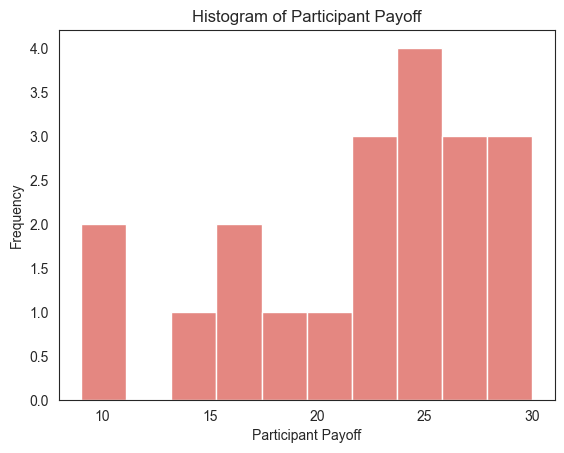

In [29]:
print(f20h1[['participant.id_in_session', 'network_experiment2.1.player.idx' ,'participant.payoff']])
sns.histplot(data=f20h1, x='participant.payoff', bins = 10)
plt.xlabel('Participant Payoff')
plt.ylabel('Frequency')
plt.title('Histogram of Participant Payoff')
plt.show()

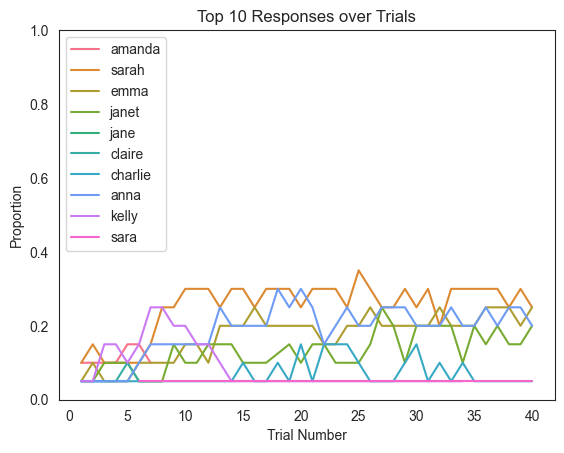

In [30]:
plot_top_k_responses(f20s3_long, k = 10)

/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/2581828263.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_df = pivot_df.applymap(lambda x: x[:6] if pd.notnull(x) else x)
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/2581828263.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_df = pivot_df.applymap(lambda x: response_to_num[x])


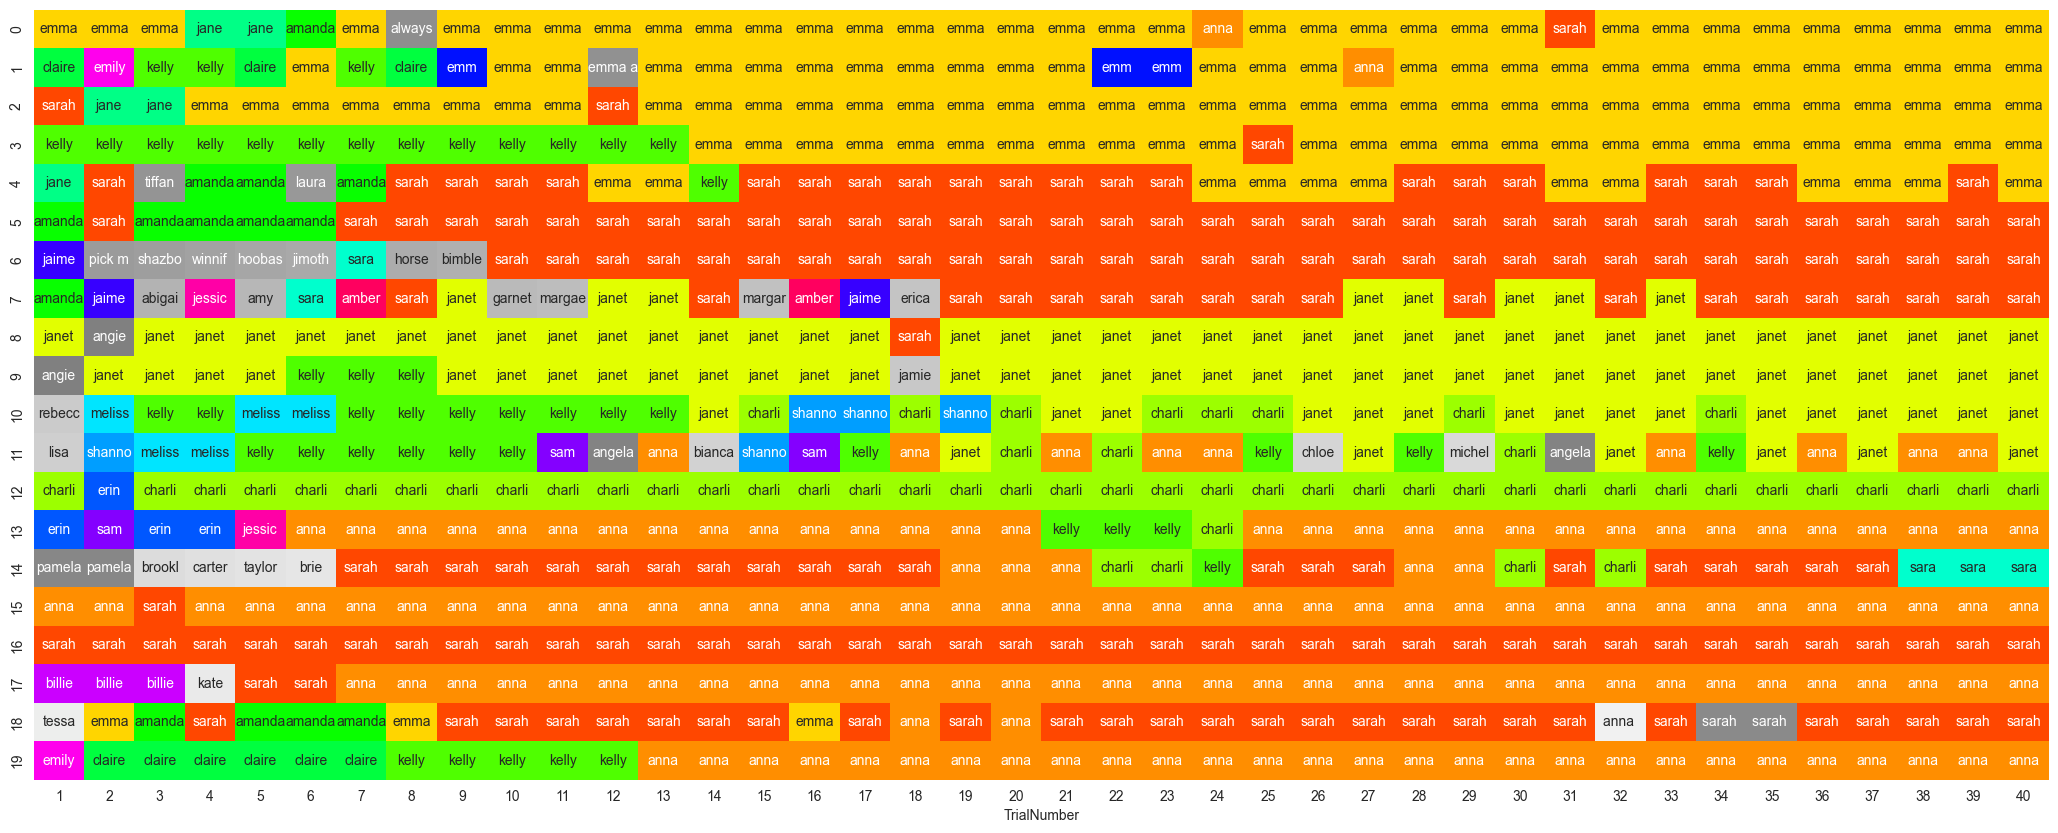

<Axes: xlabel='TrialNumber'>

In [31]:
plot_colored_responses(f20s3_long, figsize=(26, 10), colormap='hsv', annotations=True, annot_format='')

# Extract personal narrative documents from before and after network interaction
## Pre post data read in from the qualitrics experiment

In [14]:
#hashtag
h20s1pp = pd.read_csv('h20s1pp.csv')
h20s2pp = pd.read_csv('h20s2pp.csv')
h20s3pp = pd.read_csv('h20s3pp.csv')

h20h1pp = pd.read_csv('h20h1pp.csv')
h20h2pp = pd.read_csv('h20h2pp.csv')
h20h3pp = pd.read_csv('h20h3pp.csv')

h50s1pp = pd.read_csv('h50s1pp.csv').dropna()
h50s2pp = pd.read_csv('h50s2pp.csv')
h50s3pp = pd.read_csv('h50s3pp.csv')

h50h1pp = pd.read_csv('h50h1pp.csv')
h50h2pp = pd.read_csv('h50h2pp.csv')
h50h3pp = pd.read_csv('h50h3pp.csv')

h100s1pp = pd.read_csv('h100s1pp.csv').dropna()
h100h1pp = pd.read_csv('h100h1pp.csv').dropna().rename(columns={'id': 'random ID'})

In [15]:
#hashtag
f20s1pp = pd.read_csv('f20s1pp.csv')
f20s2pp = pd.read_csv('f20s2pp.csv')
f20s3pp = pd.read_csv('f20s3pp.csv')

f20h1pp = pd.read_csv('f20h1pp.csv')
f20h2pp = pd.read_csv('f20h2pp.csv')
f20h3pp = pd.read_csv('f20h3pp.csv')

f50s1pp = pd.read_csv('f50s1pp.csv')
f50s2pp = pd.read_csv('f50s2pp.csv')
f50s3pp = pd.read_csv('f50s3pp.csv')

f50h1pp = pd.read_csv('f50h1pp.csv')
f50h2pp = pd.read_csv('f50h2pp.csv')
f50h3pp = pd.read_csv('f50h3pp.csv')

In [32]:
# process hashtag data
h20s1pre, h20s1post = process_prepost_data(h20s1pp, h20s1['hashtag_experiment.1.player.idx'])
h20s2pre, h20s2post = process_prepost_data(h20s2pp, h20s2['hashtag_experiment.1.player.idx'])
h20s3pre, h20s3post = process_prepost_data(h20s3pp, h20s3['hashtag_experiment.1.player.idx'])

h20h1pre, h20h1post = process_prepost_data(h20h1pp, h20h1['hashtag_experiment.1.player.idx'])
h20h2pre, h20h2post = process_prepost_data(h20h2pp, h20h2['hashtag_experiment.1.player.idx'])
h20h3pre, h20h3post = process_prepost_data(h20h3pp, h20h3['hashtag_experiment.1.player.idx'])

h50s1pre, h50s1post = process_prepost_data(h50s1pp, h50s1['hashtag_experiment.1.player.idx'])
h50s2pre, h50s2post = process_prepost_data(h50s2pp, h50s2['hashtag_experiment.1.player.idx'])
h50s3pre, h50s3post = process_prepost_data(h50s3pp, h50s3['hashtag_experiment.1.player.idx'])

h50h1pre, h50h1post = process_prepost_data(h50h1pp, h50h1['hashtag_experiment.1.player.idx'])
h50h2pre, h50h2post = process_prepost_data(h50h2pp, h50h2['hashtag_experiment.1.player.idx'])
h50h3pre, h50h3post = process_prepost_data(h50h3pp, h50h3['hashtag_experiment.1.player.idx'])

h100s1pre, h100s1post = process_prepost_data(h100s1pp, h100s1['hashtag_experiment.1.player.idx'])
h100h1pre, h100h1post = process_prepost_data(h100h1pp, h100h1['hashtag_experiment.1.player.idx'])

/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/1987458349.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pre_hash = pre_hash.applymap(str.lower)#.applymap(stem_string)
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/1987458349.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  post_hash = post_hash.applymap(str.lower)#.applymap(stem_string)
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/1987458349.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pre_hash = pre_hash.applymap(str.lower)#.applymap(stem_string)
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/1987458349.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  post_hash = post_hash.applymap(str.lower)#.applymap(stem_string)
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/1987458349.

In [33]:
# process facename data
f20s1pre, f20s1post = process_prepost_data(f20s1pp, f20s1['network_experiment.1.player.idx'])
f20s2pre, f20s2post = process_prepost_data(f20s2pp, f20s2['network_experiment.1.player.idx'])
f20s3pre, f20s3post = process_prepost_data(f20s3pp, f20s3['network_experiment.1.player.idx'])

f20h1pre, f20h1post = process_prepost_data(f20h1pp, f20h1['network_experiment2.1.player.idx'])
f20h2pre, f20h2post = process_prepost_data(f20h2pp, f20h2['network_experiment.1.player.idx'])
f20h3pre, f20h3post = process_prepost_data(f20h3pp, f20h3['network_experiment.1.player.idx'])

f50s1pre, f50s1post = process_prepost_data(f50s1pp, f50s1['network_experiment.1.player.idx'])
f50s2pre, f50s2post = process_prepost_data(f50s2pp, f50s2['network_experiment.1.player.idx'])
f50s3pre, f50s3post = process_prepost_data(f50s3pp, f50s3['network_experiment.1.player.idx'])

f50h1pre, f50h1post = process_prepost_data(f50h1pp, f50h1['network_experiment2.1.player.idx'])
f50h2pre, f50h2post = process_prepost_data(f50h2pp, f50h2['network_experiment.1.player.idx'])
f50h3pre, f50h3post = process_prepost_data(f50h3pp, f50h3['network_experiment.1.player.idx'])


/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/1987458349.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pre_hash = pre_hash.applymap(str.lower)#.applymap(stem_string)
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/1987458349.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  post_hash = post_hash.applymap(str.lower)#.applymap(stem_string)
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/1987458349.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pre_hash = pre_hash.applymap(str.lower)#.applymap(stem_string)
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/1987458349.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  post_hash = post_hash.applymap(str.lower)#.applymap(stem_string)
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/1987458349.

In [34]:
# Create a dictionary for all ds variables (Hashtag and Face data)
pp_data_frames = {
    # Hashtag data - PRE
    'h20s1pre': h20s1pre,
    'h20s2pre': h20s2pre,
    'h20s3pre': h20s3pre,
    'h20h1pre': h20h1pre,
    'h20h2pre': h20h2pre,
    'h20h3pre': h20h3pre,
    'h50s1pre': h50s1pre,
    'h50s2pre': h50s2pre,
    'h50s3pre': h50s3pre,
    'h50h1pre': h50h1pre,
    'h50h2pre': h50h2pre,
    'h50h3pre': h50h3pre,
    'h100s1pre': h100s1pre,
    'h100h1pre': h100h1pre,

    # Face pre
    'f20s1pre': f20s1pre,
    'f20s2pre': f20s2pre,
    'f20s3pre': f20s3pre,
    'f20h1pre': f20h1pre,
    'f20h2pre': f20h2pre,
    'f20h3pre': f20h3pre,
    'f50s1pre': f50s1pre,
    'f50s2pre': f50s2pre,
    'f50s3pre': f50s3pre,
    'f50h1pre': f50h1pre,
    'f50h2pre': f50h2pre,
    'f50h3pre': f50h3pre,
    # hashtag post
    'h20s1post': h20s1post,
    'h20s2post': h20s2post,
    'h20s3post': h20s3post,
    'h20h1post': h20h1post,
    'h20h2post': h20h2post,
    'h20h3post': h20h3post,
    'h50s1post': h50s1post,
    'h50s2post': h50s2post,
    'h50s3post': h50s3post,
    'h50h1post': h50h1post,
    'h50h2post': h50h2post,
    'h50h3post': h50h3post,
    'h100s1post': h100s1post,
    'h100h1post': h100h1post,

    # Face post
    'f20s1post': f20s1post,
    'f20s2post': f20s2post,
    'f20s3post': f20s3post,
    'f20h1post': f20h1post,
    'f20h2post': f20h2post,
    'f20h3post': f20h3post,
    'f50s1post': f50s1post,
    'f50s2post': f50s2post,
    'f50s3post': f50s3post,
    'f50h1post': f50h1post,
    'f50h2post': f50h2post,
    'f50h3post': f50h3post
}

# Add an identifier column to each dataframe
for key, df in pp_data_frames.items():
    df['Identifier'] = key

# Concatenate all the dataframes into one
all_prepost = pd.concat(pp_data_frames.values(), ignore_index=True)

In [35]:
all_prepost

,random ID,ResponseItem,Response,Identifier
0,86769,hashtag1_1,earthquake,h20s1pre
1,97214,hashtag1_1,exclusionzone,h20s1pre
2,83337,hashtag1_1,remember,h20s1pre
3,19315,hashtag1_1,setsuden,h20s1pre
4,57771,hashtag1_1,heartbreaking,h20s1pre
...,...,...,...,...
20367,37462.0,tweet2,the fukushima nuclear disaster of 2011 changed...,f50h3post
20368,51810.0,tweet2,a disaster happened in the year 2011 in fukush...,f50h3post
20369,20580.0,tweet2,fukushima disaster spreading radiation across ...,f50h3post
20370,46881.0,tweet2,the impact the nuclear disaster had on fukushi...,f50h3post


In [36]:
#split identifier to make specific columns

import re
def split_identifier(identifier):
    match = re.match(r'([hf])(\d+)([sh])(\d+)(pre|post)', identifier)
    if match:
        return match.groups()
    else:
        return None, None, None, None, None

# Apply the split_identifier function to the Identifier column
all_prepost[['Content', 'Size', 'Structure', 'Run', 'Phase']] = all_prepost['Identifier'].apply(
    lambda x: pd.Series(split_identifier(x))
)

# Convert Size and Run to numeric

all_prepost['Size'] = all_prepost['Size'].astype(int)
all_prepost['Run'] = all_prepost['Run'].astype(int)

# Remap Content and Structure columns
content_mapping = {'f': 'Face', 'h': 'Hashtag'}
structure_mapping = {'h': 'Homogeneous', 's': 'Spatial'}

all_prepost['Content'] = all_prepost['Content'].map(content_mapping)
all_prepost['Structure'] = all_prepost['Structure'].map(structure_mapping)

In [37]:
tweets = all_prepost[all_prepost['ResponseItem'].isin(['tweet1', 'tweet2'])]

In [38]:
tweets

,random ID,ResponseItem,Response,Identifier,Content,Size,Structure,Run,Phase
190,86769,tweet1,the natural disaster of tohoku earthquake caus...,h20s1pre,Hashtag,20,Spatial,1,pre
191,97214,tweet1,fukushima nuclear disaster caused by the most ...,h20s1pre,Hashtag,20,Spatial,1,pre
192,83337,tweet1,have you guys heard about the massive nuclear ...,h20s1pre,Hashtag,20,Spatial,1,pre
193,19315,tweet1,the tsunami that happened in fukushima is desa...,h20s1pre,Hashtag,20,Spatial,1,pre
194,57771,tweet1,"this is a tragedy, i have so much empathy for ...",h20s1pre,Hashtag,20,Spatial,1,pre
...,...,...,...,...,...,...,...,...,...
20367,37462.0,tweet2,the fukushima nuclear disaster of 2011 changed...,f50h3post,Face,50,Homogeneous,3,post
20368,51810.0,tweet2,a disaster happened in the year 2011 in fukush...,f50h3post,Face,50,Homogeneous,3,post
20369,20580.0,tweet2,fukushima disaster spreading radiation across ...,f50h3post,Face,50,Homogeneous,3,post
20370,46881.0,tweet2,the impact the nuclear disaster had on fukushi...,f50h3post,Face,50,Homogeneous,3,post


In [39]:
tweets.to_csv('all_tweets.csv') #this dataframe is analyzed by running tweets through the causal language anlysis pipeline at causal-claims.isi.edu. Extracted claims analyzed in R script.

# Make full dataframe (with computed decision strategies) and then merge to make a single dataframe; statistical analysis in R.


In [40]:
#Hashtag data
h20s1_ds = get_decision_strategies(h20s1_long)
h20s2_ds = get_decision_strategies(h20s2_long)
h20s3_ds = get_decision_strategies(h20s3_long)

h20h1_ds = get_decision_strategies(h20h1_long)
h20h2_ds = get_decision_strategies(h20h2_long)
h20h3_ds = get_decision_strategies(h20h3_long)

h50s1_ds = get_decision_strategies(h50s1_long)
h50s2_ds = get_decision_strategies(h50s2_long)
h50s3_ds = get_decision_strategies(h50s3_long)

h50h1_ds = get_decision_strategies(h50h1_long)
h50h2_ds = get_decision_strategies(h50h2_long)
h50h3_ds = get_decision_strategies(h50h3_long)

h100s1_ds = get_decision_strategies(h100s1_long)
h100h1_ds = get_decision_strategies(h100h1_long)

/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/2446452798.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'B' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  exp_df.loc[(exp_df.id == node) & (exp_df.TrialNumber == t), 'BC'] = 'B'
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/2446452798.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'B' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  exp_df.loc[(exp_df.id == node) & (exp_df.TrialNumber == t), 'BC'] = 'B'
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/2446452798.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'B' has dtype incompatible with float64, please explicitly cast to

In [41]:
#Face data

f20s1_ds = get_decision_strategies(f20s1_long)
f20s2_ds = get_decision_strategies(f20s2_long)
f20s3_ds = get_decision_strategies(f20s3_long)

f20h1_ds = get_decision_strategies(f20h1_long)
f20h2_ds = get_decision_strategies(f20h2_long)
f20h3_ds = get_decision_strategies(f20h3_long)

f50s1_ds = get_decision_strategies(f50s1_long)
f50s2_ds = get_decision_strategies(f50s2_long)
f50s3_ds = get_decision_strategies(f50s3_long)

f50h1_ds = get_decision_strategies(f50h1_long)
f50h2_ds = get_decision_strategies(f50h2_long)
f50h3_ds = get_decision_strategies(f50h3_long)

/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/2446452798.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'B' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  exp_df.loc[(exp_df.id == node) & (exp_df.TrialNumber == t), 'BC'] = 'B'
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/2446452798.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'B' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  exp_df.loc[(exp_df.id == node) & (exp_df.TrialNumber == t), 'BC'] = 'B'
/var/folders/jc/2d8921xj49bgvjh4p36ptbcc0000gn/T/ipykernel_60104/2446452798.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'B' has dtype incompatible with float64, please explicitly cast to

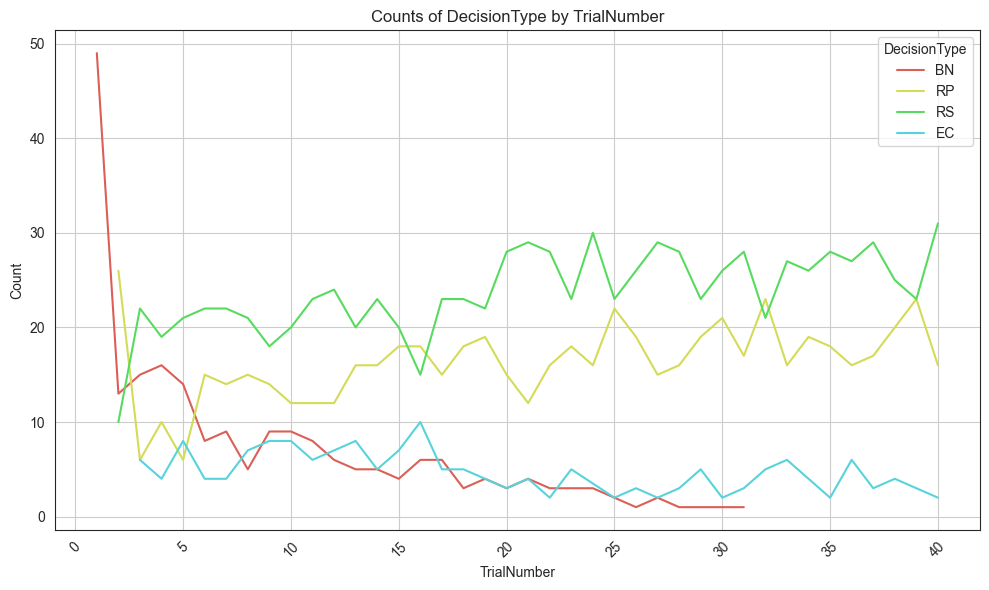

In [43]:
#View a single run?
counts = f50s2_ds.groupby(['TrialNumber', 'DecisionType']).size().reset_index(name='Count')
# Plot using Seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.lineplot(x='TrialNumber', y='Count', hue='DecisionType', data=counts)
plt.title('Counts of DecisionType by TrialNumber')
plt.xlabel('TrialNumber')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.grid(True)
plt.legend(title='DecisionType')  # Add legend with DecisionType categories
plt.tight_layout()
plt.show()

In [44]:
# Create a dictionary for all ds variables (Hashtag and Face data)
all_data_frames = {
    # Hashtag data
    'h20s1': h20s1_ds,
    'h20s2': h20s2_ds,
    'h20s3': h20s3_ds,
    'h20h1': h20h1_ds,
    'h20h2': h20h2_ds,
    'h20h3': h20h3_ds,
    'h50s1': h50s1_ds,
    'h50s2': h50s2_ds,
    'h50s3': h50s3_ds,
    'h50h1': h50h1_ds,
    'h50h2': h50h2_ds,
    'h50h3': h50h3_ds,
    'h100s1': h100s1_ds,
    'h100h1': h100h1_ds,

    # Face data
    'f20s1': f20s1_ds,
    'f20s2': f20s2_ds,
    'f20s3': f20s3_ds,
    'f20h1': f20h1_ds,
    'f20h2': f20h2_ds,
    'f20h3': f20h3_ds,
    'f50s1': f50s1_ds,
    'f50s2': f50s2_ds,
    'f50s3': f50s3_ds,
    'f50h1': f50h1_ds,
    'f50h2': f50h2_ds,
    'f50h3': f50h3_ds
}

# Add an identifier column to each dataframe
for key, df in all_data_frames.items():
    df['Identifier'] = key

# Concatenate all the dataframes into one
all_ds_dfs = pd.concat(all_data_frames.values(), ignore_index=True)

# Print or return the final dataframe
#print(all_decision_strategies)

In [45]:
# Split the Identifier column
all_ds_dfs['Content'] = all_ds_dfs['Identifier'].str[0]
all_ds_dfs['Size'] = all_ds_dfs['Identifier'].str[1:-2]
all_ds_dfs['Structure'] = all_ds_dfs['Identifier'].str[-2]
all_ds_dfs['Run'] = all_ds_dfs['Identifier'].str[-1]

# Convert Size and Run to numeric
all_ds_dfs['Size'] = all_ds_dfs['Size'].astype(int)
all_ds_dfs['Run'] = all_ds_dfs['Run'].astype(int)

# Remap Content and Structure columns
content_mapping = {'f': 'Face', 'h': 'Hashtag'}
structure_mapping = {'h': 'Homogeneous', 's': 'Spatial'}

all_ds_dfs['Content'] = all_ds_dfs['Content'].map(content_mapping)
all_ds_dfs['Structure'] = all_ds_dfs['Structure'].map(structure_mapping)

# Print or return the final dataframe
#print(all_ds_dfs)


In [46]:
all_ds_dfs.to_csv('all_interaction_data.csv', index = False)

In [47]:
#number of subjects unique subjects
all_ds_dfs['random ID'].nunique()

989

In [48]:
all_ds_dfs #39160 interactions (unique rows)

,id,random ID,ResponseType,TrialNumber,Response,Group,Points,prev_response,partner_id,partner_prev_response,partner_response,old_decisiontype,BC,DecisionType,Identifier,Content,Size,Structure,Run
0,0,89545.0,hashtag,1,stopnuclearpower,5.0,0.0,nan,18.0,None,saveenergy,NEW,B,BN,h20s1,Hashtag,20,Spatial,1
1,0,89545.0,hashtag,2,endnuclear,8.0,0.0,stopnuclearpower,18.0,saveenergy,saveenergy,NEW,B,BN,h20s1,Hashtag,20,Spatial,1
2,0,89545.0,hashtag,3,saveenergy,9.0,1.0,endnuclear,18.0,saveenergy,saveenergy,RP,C,RP,h20s1,Hashtag,20,Spatial,1
3,0,89545.0,hashtag,4,saveenergy,9.0,0.0,saveenergy,2.0,saveenergy,radiation,RP,C,RP,h20s1,Hashtag,20,Spatial,1
4,0,89545.0,hashtag,5,radiation,1.0,0.0,saveenergy,1.0,radiation,electricity,RP,C,RP,h20s1,Hashtag,20,Spatial,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39155,49,78845,name,36,emily,24.0,1.0,emily,10.0,emily,emily,RP,C,RP,f50h3,Face,50,Homogeneous,3
39156,49,78845,name,37,emily,7.0,1.0,emily,39.0,emily,emily,RS,C,RS,f50h3,Face,50,Homogeneous,3
39157,49,78845,name,38,emily,6.0,1.0,emily,20.0,emily,emily,RP,C,RP,f50h3,Face,50,Homogeneous,3
39158,49,78845,name,39,emily,25.0,1.0,emily,0.0,emily,emily,RP,C,RP,f50h3,Face,50,Homogeneous,3
